In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from datetime import *
from datetime import datetime, timedelta
from sqlalchemy import extract
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy import and_

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
Measurement.metadata.tables['measurement']

Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None)

In [11]:
# Create our session (link) from Python to the DB
Station.metadata.tables['station']

Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)

In [12]:
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
max_date_str = session.query(func.max(Measurement.date)).scalar()
max_date = datetime.strptime(max_date_str, '%Y-%m-%d').date()
print(max_date)

2017-08-23


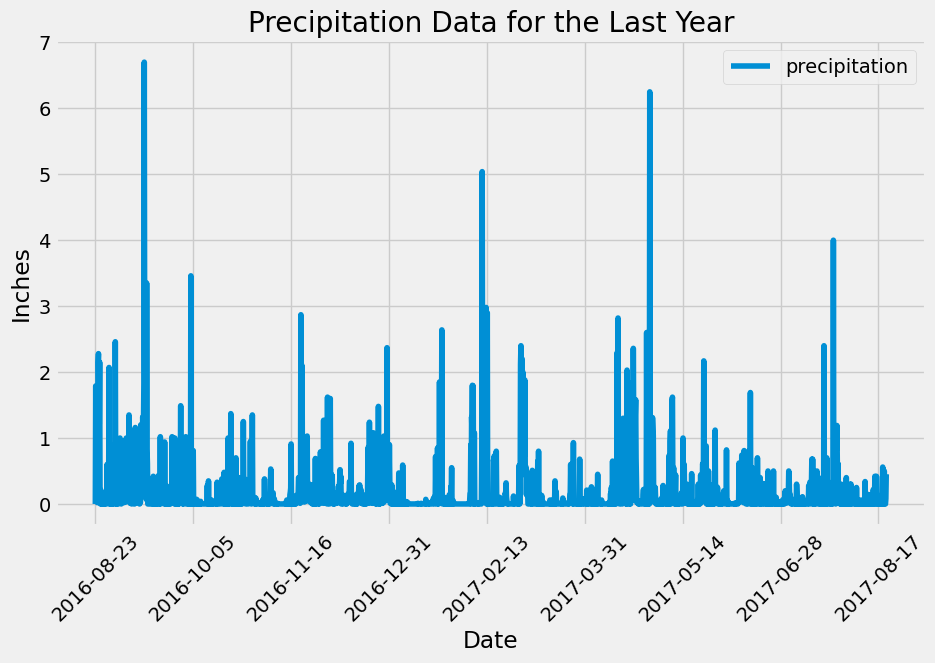

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
max_date_str = session.query(func.max(Measurement.date)).scalar()
max_date = datetime.strptime(max_date_str, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
one_year_ago = max_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(Measurement.date, Measurement.prcp)\
                 .filter(Measurement.date >= one_year_ago)\
                 .all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(last_year_data, columns=['Date', 'precipitation'])

# display the first few rows of the DataFrame
precipitation_df.head()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')
# Dropping the Nan values in precipitation column
precipitation_df = precipitation_df.dropna(subset=['precipitation'])

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='precipitation', figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.title('Precipitation Data for the Last Year')
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['precipitation'].describe()
precipitation_summary

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [16]:
# Join the station and measurement tables for some of the queries.
results = session.query(Measurement, Station)\
          .join(Station, Measurement.station == Station.station)\
          .all()
# for measurement, station in results:
#     print(f"{measurement.station}, {station.name}")

In [17]:
# Design a query to calculate the total number of stations in the dataset
print(session.query(Measurement).group_by(Measurement.station).count())

9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = session.query(Measurement.station, func.count().label('observation_count')).\
        group_by(Measurement.station).\
        order_by(func.count().desc())

# Execute the query and return all the results as a list of tuples
for row in query:
    print(row.station, row.observation_count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

query = session.query(
        func.min(Measurement.tobs).label('lowest_temperature'),
        func.max(Measurement.tobs).label('highest_temperature'),
        func.avg(Measurement.tobs).label('average_temperature')
    ).filter(
        Measurement.station == most_active_station_id
    )

# Execute the query and return the results as a tuple
result = query.one()
print(result)

(54.0, 85.0, 71.66378066378067)


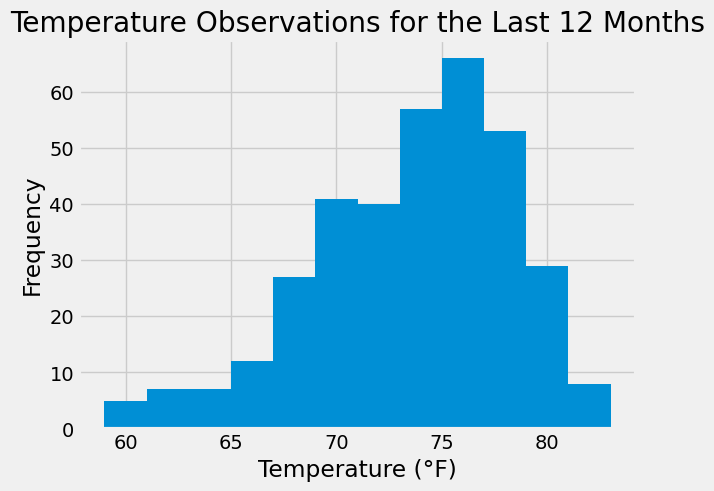

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = 'USC00519281'
# Define the start and end date for the query
max_date_str = session.query(func.max(Measurement.date)).scalar()
max_date = datetime.strptime(max_date_str, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
one_year_ago = max_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
query = session.query(Measurement.tobs).filter(and_(Measurement.station == most_active_station_id, Measurement.date >= one_year_ago)
)

# Execute the query and retrieve the results as a list of temperatures
temperatures = [result[0] for result in query]

# Plot the temperatures as a histogram using Matplotlib
plt.hist(temperatures, bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Last 12 Months')
plt.show()


# Close Session

In [21]:
# Close Session
session.close()